<a href="https://colab.research.google.com/github/ambruhsia/Pyspark-BigDataProjectHeartdisease/blob/main/BigDataProjectHeartdisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
johnsmith88_heart_disease_dataset_path = kagglehub.dataset_download('johnsmith88/heart-disease-dataset')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator



# Create Spark session
spark = SparkSession.builder.appName("HeartDiseasePrediction").getOrCreate()

# Load the dataset (replace 'path_to_dataset.csv' with your file path)
data = spark.read.csv("/kaggle/input/heart-disease-dataset/heart.csv", header=True, inferSchema=True)

# Display schema
data.printSchema()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/17 09:31:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Rename columns to align with feature names (if needed)
data = data.withColumnRenamed("cp", "chest_pain_type") \
           .withColumnRenamed("trestbps", "resting_bp") \
           .withColumnRenamed("chol", "cholesterol") \
           .withColumnRenamed("fbs", "fasting_blood_sugar") \
           .withColumnRenamed("restecg", "rest_ecg") \
           .withColumnRenamed("thalach", "max_heart_rate") \
           .withColumnRenamed("exang", "exercise_angina") \
           .withColumnRenamed("oldpeak", "st_depression") \
           .withColumnRenamed("ca", "num_major_vessels")

# Handle missing values
data = data.fillna({
    "cholesterol": data.select("cholesterol").dropna().rdd.map(lambda x: x[0]).mean(),
    "thal": data.groupBy("thal").count().orderBy("count", ascending=False).first()["thal"]
})

# Convert categorical variables to numeric using StringIndexer
indexers = [
    StringIndexer(inputCol="sex", outputCol="sex_indexed"),
    StringIndexer(inputCol="chest_pain_type", outputCol="chest_pain_type_indexed"),
    StringIndexer(inputCol="rest_ecg", outputCol="rest_ecg_indexed"),
    StringIndexer(inputCol="thal", outputCol="thal_indexed")
]

for indexer in indexers:
    data = indexer.fit(data).transform(data)

# Feature engineering: Cholesterol-to-Age ratio
data = data.withColumn("cholesterol_age_ratio", col("cholesterol") / col("age"))

# Assemble features into a single vector
feature_cols = ["age", "sex_indexed", "chest_pain_type_indexed", "resting_bp", "cholesterol",
                "max_heart_rate", "exercise_angina", "st_depression", "num_major_vessels",
                "thal_indexed", "cholesterol_age_ratio"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# Prepare the final dataset for modeling
final_data = data.select(col("scaled_features").alias("features"), col("target").alias("label"))


IllegalArgumentException: requirement failed: Output column sex_indexed already exists.

In [ ]:
# Split dataset into training and testing sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_model = rf.fit(train_data)


In [ ]:
# Evaluate Logistic Regression
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")

lr_auc = evaluator.evaluate(lr_predictions)
rf_auc = evaluator.evaluate(rf_predictions)

print(f"Logistic Regression AUC: {lr_auc}")
print(f"Random Forest AUC: {rf_auc}")

# Confusion Matrix
lr_predictions.groupBy("label", "prediction").count().show()
rf_predictions.groupBy("label", "prediction").count().show()


Logistic Regression AUC: 0.9207865168539328
Random Forest AUC: 0.9772471910112359
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   13|
|    0|       0.0|   68|
|    1|       1.0|   76|
|    0|       1.0|   12|
+-----+----------+-----+

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    8|
|    0|       0.0|   70|
|    1|       1.0|   81|
|    0|       1.0|   10|
+-----+----------+-----+



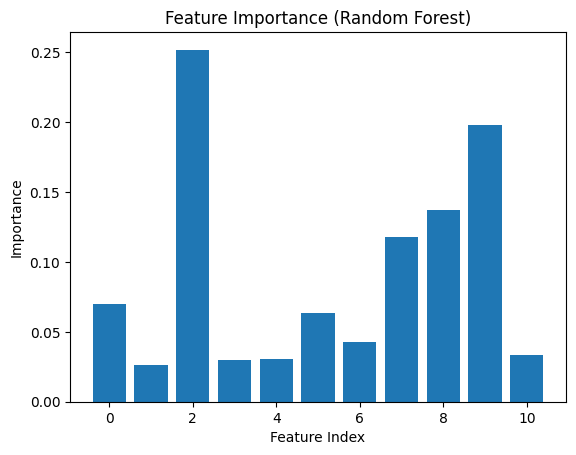

In [ ]:
import matplotlib.pyplot as plt

# Feature importance for Random Forest
rf_importances = rf_model.featureImportances
x_values = list(range(len(rf_importances)))
plt.bar(x_values, rf_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Evaluators
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

# Function to evaluate and return metrics
def evaluate_classification_model(predictions, model_name):
    accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
    precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
    recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
    f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})
    roc_auc = binary_evaluator.evaluate(predictions)

    return {
        "Model Name": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC": roc_auc
    }

# Example: Evaluating Logistic Regression
lr_predictions = lr_model.transform(test_data)
lr_metrics = evaluate_classification_model(lr_predictions, "Logistic Regression")

# Example: Evaluating Random Forest
rf_predictions = rf_model.transform(test_data)
rf_metrics = evaluate_classification_model(rf_predictions, "Random Forest")

# Combine results into a list
classification_results = [lr_metrics, rf_metrics]

# Print the results
for result in classification_results:
    print(result)


{'Model Name': 'Logistic Regression', 'Accuracy': 0.8520710059171598, 'Precision': 0.852213788111224, 'Recall': 0.8520710059171598, 'F1-Score': 0.8521125342167233, 'ROC': 0.9207865168539328}
{'Model Name': 'Random Forest', 'Accuracy': 0.893491124260355, 'Precision': 0.8935778225719053, 'Recall': 0.893491124260355, 'F1-Score': 0.8934087334282077, 'ROC': 0.9772471910112359}


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, MultilayerPerceptronClassifier

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dt_model = dt_classifier.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_metrics = evaluate_classification_model(dt_predictions, "Decision Tree")

# Gradient-Boosted Tree Classifier
gbt_classifier = GBTClassifier(featuresCol="features", labelCol="label", maxIter=20)
gbt_model = gbt_classifier.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_metrics = evaluate_classification_model(gbt_predictions, "Gradient-Boosted Tree")

# Multilayer Perceptron Classifier (Neural Network)
layers = [len(feature_cols), 8, 4, 2]  # Input layer, hidden layers, and output layer
mlp_classifier = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label", layers=layers, maxIter=100)
mlp_model = mlp_classifier.fit(train_data)
mlp_predictions = mlp_model.transform(test_data)
mlp_metrics = evaluate_classification_model(mlp_predictions, "Multilayer Perceptron")

# Add to classification results
classification_results.extend([dt_metrics, gbt_metrics, mlp_metrics])

# Print classification results
for result in classification_results:
    print(result)


{'Model Name': 'Logistic Regression', 'Accuracy': 0.8520710059171598, 'Precision': 0.852213788111224, 'Recall': 0.8520710059171598, 'F1-Score': 0.8521125342167233, 'ROC': 0.9207865168539328}
{'Model Name': 'Random Forest', 'Accuracy': 0.893491124260355, 'Precision': 0.8935778225719053, 'Recall': 0.893491124260355, 'F1-Score': 0.8934087334282077, 'ROC': 0.9772471910112359}
{'Model Name': 'Decision Tree', 'Accuracy': 0.9171597633136095, 'Precision': 0.9171597633136095, 'Recall': 0.9171597633136095, 'F1-Score': 0.9171597633136095, 'ROC': 0.9253511235955056}
{'Model Name': 'Gradient-Boosted Tree', 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'ROC': 1.0}
{'Model Name': 'Multilayer Perceptron', 'Accuracy': 0.8875739644970414, 'Precision': 0.8882752697870053, 'Recall': 0.8875739644970415, 'F1-Score': 0.8876449081828979, 'ROC': 0.9313202247191015}


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluator
reg_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# Function to evaluate and return metrics
def evaluate_regression_model(predictions, model_name):
    rmse = reg_evaluator.evaluate(predictions, {reg_evaluator.metricName: "rmse"})
    mse = reg_evaluator.evaluate(predictions, {reg_evaluator.metricName: "mse"})
    mae = reg_evaluator.evaluate(predictions, {reg_evaluator.metricName: "mae"})
    r2 = reg_evaluator.evaluate(predictions, {reg_evaluator.metricName: "r2"})
    mape = predictions.selectExpr("abs(label - prediction)/label as ape").agg({"ape": "avg"}).collect()[0][0] * 100

    return {
        "Model Name": model_name,
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R-squared": r2,
        "MAPE": mape
    }

# Example: Evaluating Linear Regression
from pyspark.ml.regression import LinearRegression

lr_regressor = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr_regressor.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_regression_metrics = evaluate_regression_model(lr_predictions, "Linear Regression")

# Combine results into a list
regression_results = [lr_regression_metrics]

# Print the results
for result in regression_results:
    print(result)


24/11/17 09:44:29 WARN Instrumentation: [cbc2219d] regParam is zero, which might cause numerical instability and overfitting.
24/11/17 09:44:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


{'Model Name': 'Linear Regression', 'RMSE': 0.34464679755452704, 'MSE': 0.11878141506459114, 'MAE': 0.27115824851727083, 'R-squared': 0.5235230343174455, 'MAPE': 27.427104437349136}


In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import IsotonicRegression, GeneralizedLinearRegression

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
train_scaled = scaler.fit(train_data).transform(train_data)
test_scaled = scaler.fit(test_data).transform(test_data)

# Isotonic Regression
iso_regressor = IsotonicRegression(featuresCol="scaledFeatures", labelCol="label", isotonic=True)
iso_model = iso_regressor.fit(train_scaled)
iso_predictions = iso_model.transform(test_scaled)
iso_regression_metrics = evaluate_regression_model(iso_predictions, "Isotonic Regression")

# Generalized Linear Regression with regularization
glr_regressor = GeneralizedLinearRegression(featuresCol="scaledFeatures", labelCol="label", family="gaussian", link="identity", regParam=0.01)
glr_model = glr_regressor.fit(train_scaled)
glr_predictions = glr_model.transform(test_scaled)
glr_regression_metrics = evaluate_regression_model(glr_predictions, "Generalized Linear Regression")


In [ ]:
import numpy as np
from pyspark.ml.linalg import DenseVector

# Convert Spark DataFrame to Dense NumPy arrays
def convert_to_numpy(dataframe):
    features = np.array([np.array(row['features'].toArray()) for row in dataframe.collect()])
    labels = np.array([row['label'] for row in dataframe.collect()])
    return features, labels

# Convert train and test datasets
train_features, train_labels = convert_to_numpy(train_data)
test_features, test_labels = convert_to_numpy(test_data)

# Define a simple neural network model
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(feature_cols),)),  # Input shape based on number of features
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(train_features, train_labels, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_mae = model.evaluate(test_features, test_labels)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6041 - mae: 0.6430 - val_loss: 0.2126 - val_mae: 0.3903
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2684 - mae: 0.4218 - val_loss: 0.1360 - val_mae: 0.3035
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1862 - mae: 0.3413 - val_loss: 0.1197 - val_mae: 0.2746
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1565 - mae: 0.3159 - val_loss: 0.1244 - val_mae: 0.2823
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1459 - mae: 0.3061 - val_loss: 0.1245 - val_mae: 0.2823
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1397 - mae: 0.3057 - val_loss: 0.1279 - val_mae: 0.2900
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1243 - mae: 0.2817 - val_loss: 0.1376 - val_mae: 0.2991
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1322 - mae: 0.2931 - val_loss: 0.1603 - val_mae: 0.3155
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1294 - mae:

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import IsotonicRegression, GeneralizedLinearRegression

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
train_scaled = scaler.fit(train_data).transform(train_data)
test_scaled = scaler.fit(test_data).transform(test_data)

# Isotonic Regression
iso_regressor = IsotonicRegression(featuresCol="scaledFeatures", labelCol="label", isotonic=True)
iso_model = iso_regressor.fit(train_scaled)
iso_predictions = iso_model.transform(test_scaled)
iso_regression_metrics = evaluate_regression_model(iso_predictions, "Isotonic Regression")
print("Isotonic Regression Metrics:", iso_regression_metrics)

# Generalized Linear Regression with regularization
glr_regressor = GeneralizedLinearRegression(featuresCol="scaledFeatures", labelCol="label", family="gaussian", link="identity", regParam=0.01)
glr_model = glr_regressor.fit(train_scaled)
glr_predictions = glr_model.transform(test_scaled)
glr_regression_metrics = evaluate_regression_model(glr_predictions, "Generalized Linear Regression")
print("Generalized Linear Regression Metrics:", glr_regression_metrics)



Isotonic Regression Metrics: {'Model Name': 'Isotonic Regression', 'RMSE': 0.4967102466259371, 'MSE': 0.24672106910319924, 'MAE': 0.4959692435995373, 'R-squared': 0.010308924907798556, 'MAPE': 48.75364082827924}
Generalized Linear Regression Metrics: {'Model Name': 'Generalized Linear Regression', 'RMSE': 0.34340366213111906, 'MSE': 0.11792607516506376, 'MAE': 0.26816772757026375, 'R-squared': 0.5269541246082323, 'MAPE': 26.18080423813617}


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set Seaborn style
sns.set(style="whitegrid")

# If you have the dataset in a Pandas DataFrame format
# df = pd.read_csv('your_dataset.csv')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


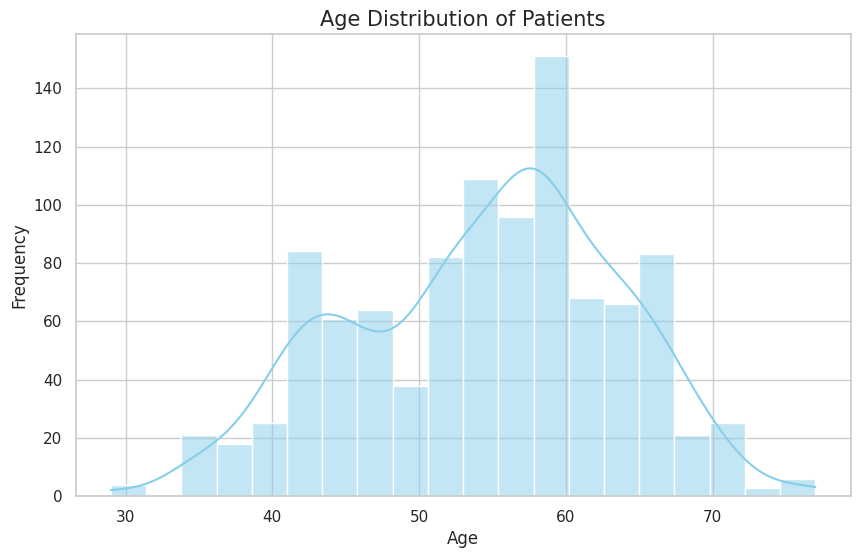

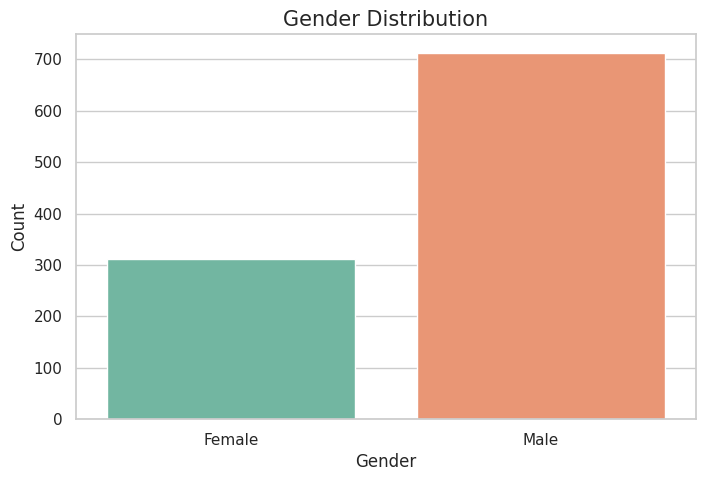

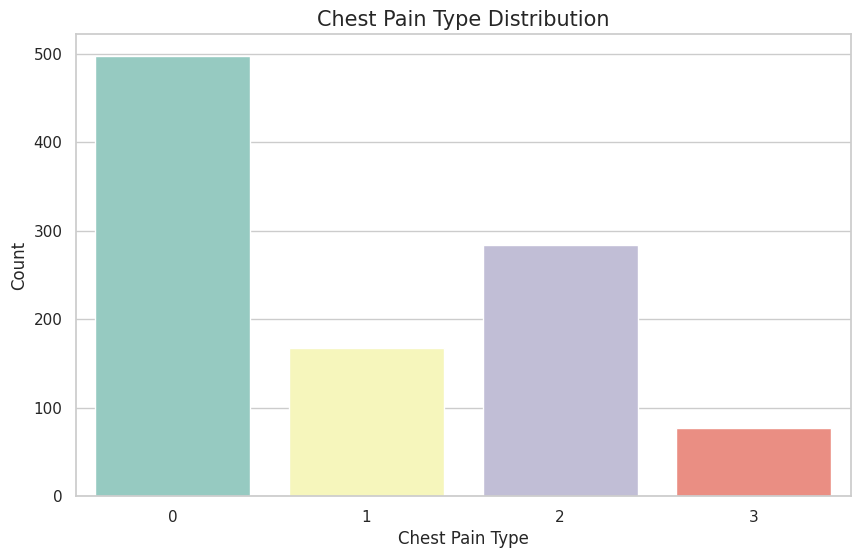

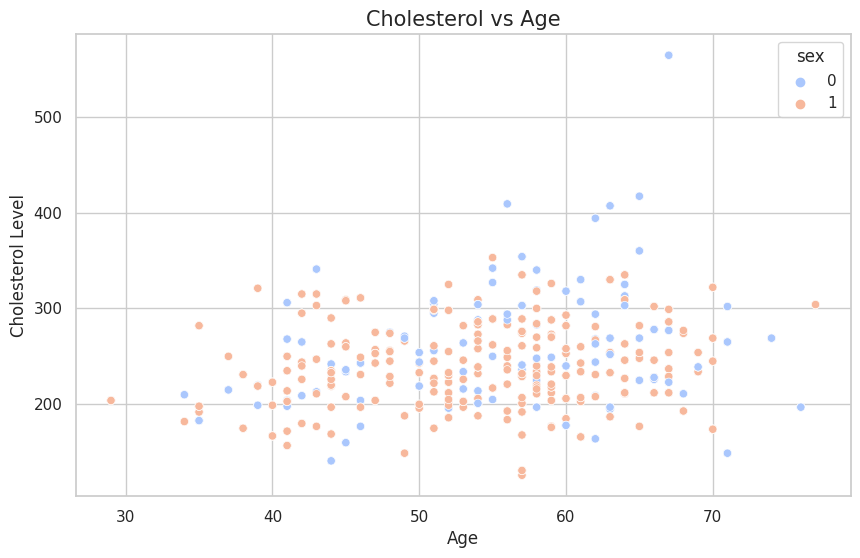

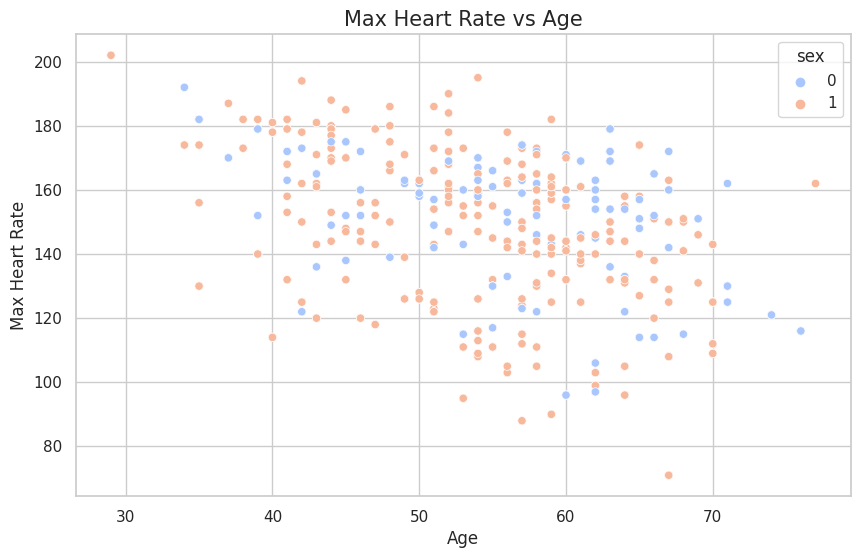

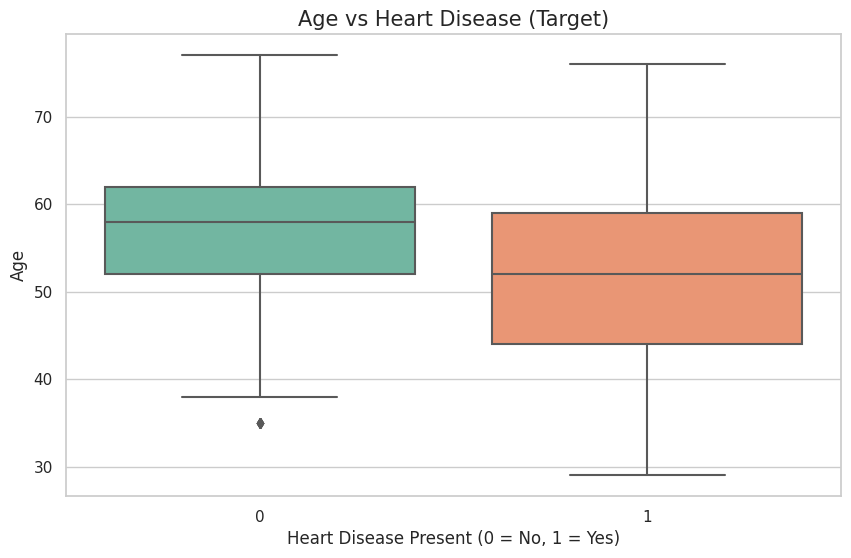

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


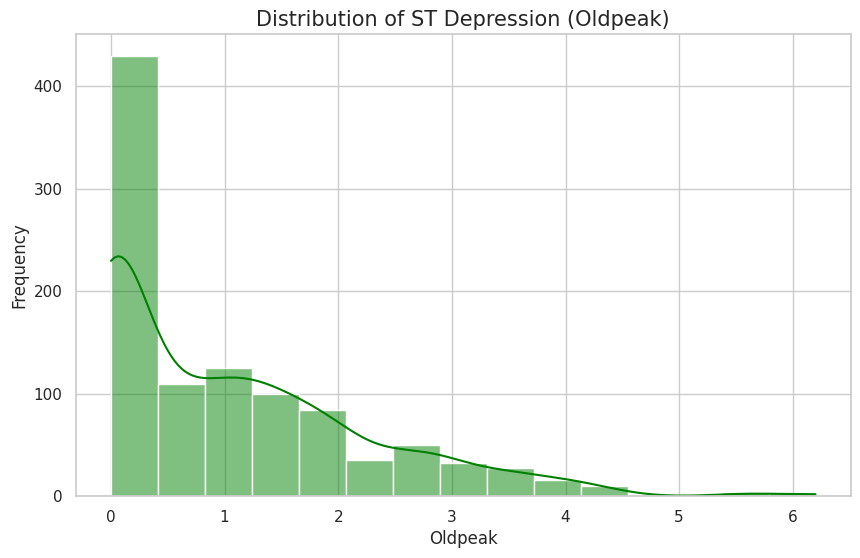

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['age'], kde=True, color='skyblue', bins=20)
plt.title('Age Distribution of Patients', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# 2. Gender Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sex', data=pandas_df, palette='Set2')
plt.title('Gender Distribution', fontsize=15)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'])
plt.show()

# 3. Chest Pain Type Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='chest_pain_type', data=pandas_df, palette='Set3')
plt.title('Chest Pain Type Distribution', fontsize=15)
plt.xlabel('Chest Pain Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


# 5. Cholesterol vs Age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='cholesterol', data=pandas_df, hue='sex', palette='coolwarm')
plt.title('Cholesterol vs Age', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Cholesterol Level', fontsize=12)
plt.show()

# 6. Max Heart Rate vs Age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='max_heart_rate', data=pandas_df, hue='sex', palette='coolwarm')
plt.title('Max Heart Rate vs Age', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Max Heart Rate', fontsize=12)
plt.show()

# 7. Boxplot for Age and Target Variable (Heart Disease)
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='age', data=pandas_df, palette='Set2')
plt.title('Age vs Heart Disease (Target)', fontsize=15)
plt.xlabel('Heart Disease Present (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.show()

# 8. Distribution of St Depression (oldpeak)
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['st_depression'], kde=True, color='green', bins=15)
plt.title('Distribution of ST Depression (Oldpeak)', fontsize=15)
plt.xlabel('Oldpeak', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# 9. Pairplot for All Numeric Features
plt.figure(figsize=(12, 10))
sns.pairplot(pandas_df, hue='target', palette='Set1', diag_kind='kde')
plt.suptitle('Pairplot of Features', fontsize=15)
plt.show()

In [ ]:

# Extract feature columns from the DenseVector in 'features' column
from pyspark.ml.linalg import DenseVector
import pandas as pd

# Function to extract individual features from the DenseVector column
def extract_features(df, feature_col):
    # Extracts the DenseVector from the features column and converts them into individual columns
    features_df = df.select(feature_col).rdd.map(lambda row: row[0].toArray()).toDF()
    feature_names = [f"feature_{i}" for i in range(features_df.count())]
    features_df = features_df.toPandas()
    features_df.columns = feature_names
    return features_df

# Extract features from the DenseVector 'features' column
features_df = extract_features(pandas_df, 'features')

# Merge with the rest of the DataFrame (if you need to keep other non-numeric columns)
pandas_df = pandas_df.drop('features', axis=1)  # Drop the 'features' column
pandas_df = pd.concat([pandas_df, features_df], axis=1)  # Add the features as individual columns

# Now you can calculate the correlation heatmap
plt.figure(figsize=(12, 8))
corr = pandas_df.corr()  # Correlation of the numeric features
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=15)
plt.show()
